# 이곳에서는
각 영화의 박스오피스 특징을 살펴본다  
특히 초반 흥행, 추반 입소문 영화를 구분하는데에 도전한다

이전 분석에서는 총 관객수와 총 상영주차, 상영횟수는 상관이 없었다.  
현재 분석에서는 총 관객수와 총 상영주차 두 데이터를 사용한다.  
그 이유는 2주차 까지의 데이터가 총 관객수와 큰 차이가 없을 경우 초반 흥행으로 판단할 수 있기 때문이다.  
따라서 최종 분석에서는 2주차 까지의 영화 패턴이랑 예측한 총 관객수 두개를 결합 비교해야 한다.  
총 상영주차는 총 관객수와 상관이 없으므로 예측 모델을 생성할 수 없었다. (그냥 지멋대로라고 생각한다)  
따라서 이거는 영화 데이터의 분포적 특성을 통해 파악할 수 있도록 한다. (이걸 통해 예측을 대체할 수 있을지도)

즉, 해당 분석에서 총 관객수는 사용해도 괜찮다. 최종 분석에서는 2주차 데이터 + 예측 총 관객수 데이터를 사용하기 때문이다 (물론 해당 모델의 신뢰도가 높아야 한다)  
따라서 총 상영주차는 분석의 재료로 사용되어서는 안된다. 분석의 대상이 되어야 한다.

# 라이브러리

In [293]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from yellowbrick.cluster import SilhouetteVisualizer
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from sklearn.preprocessing import StandardScaler
import ast
from matplotlib import colormaps
from matplotlib import patches as mpatches
import math
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import kruskal, f_oneway
import scikit_posthocs as sp
from scipy.stats import spearmanr
from scipy.stats import median_test


In [294]:
%load_ext koreanize_matplotlib


The koreanize_matplotlib module is not an IPython extension.


# 데이터

1만명 ~ 500만명 영화만 사용한다  
현재의 분석에선 배우, 감독 장르 벡터는 사용하지 않는다

In [295]:
data_train = pd.read_csv("../model/model_train_data.csv", encoding="utf-8-sig")
data_test = pd.read_csv("../model/model_test_data.csv", encoding="utf-8-sig")
data_full = pd.concat([data_train, data_test], axis=0).reset_index(drop=True)

In [296]:
data_full.to_csv("full_data_for_week_predict.csv", index=False, encoding="utf-8-sig")

각 영화의 장르 벡터도 가져온다 (배우, 감독 장르 벡터가 아니다)

In [297]:
movie_genre = pd.read_csv("../analysis/movie_genre_multi_hot.csv", encoding="utf-8-sig")

In [298]:
movie_genre.head()

,Movie_Title,genre_multi_hot
0,#살아있다,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,#아이엠히어,"[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2,#위왓치유,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,(여자)아이들 월드투어 [아이돌] 인 시네마,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,0.0MHz,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [299]:
def _ensure_list_of_ints(x):
    """
    genre_multi_hot이 object형(리스트) 또는 문자열('[0,1,0,...]')이어도
    안전하게 정수 리스트로 변환
    """
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return None
    if isinstance(x, list):
        return [int(v) for v in x]
    if isinstance(x, np.ndarray):
        return [int(v) for v in x.tolist()]
    if isinstance(x, str):
        s = x.strip()
        try:
            arr = ast.literal_eval(s)  # '[0,1,0]' → [0,1,0]
            return [int(v) for v in arr]
        except Exception:
            # '0,1,0' 같은 형태 대비
            s = s.strip("[]")
            parts = [p.strip() for p in s.split(",") if p.strip() != ""]
            return [int(float(p)) for p in parts]
    # 그 외 타입은 실패 처리
    raise ValueError(f"genre_multi_hot 값을 리스트로 변환할 수 없습니다: {x}")

In [300]:
genre_vector = pd.DataFrame(list(movie_genre["genre_multi_hot"].apply(_ensure_list_of_ints)), columns=['드라마', '멜로/로맨스', '다큐멘터리', '공연', '공포(호러)', '액션', '애니메이션', '코미디', '스릴러', 'SF', '미스터리', '어드벤처', '범죄', '판타지', '전쟁', '가족', '사극', '뮤지컬'])
genre_vector.head(2)

,드라마,멜로/로맨스,다큐멘터리,공연,공포(호러),액션,애니메이션,코미디,스릴러,SF,미스터리,어드벤처,범죄,판타지,전쟁,가족,사극,뮤지컬
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [301]:
movie_genre = pd.concat([movie_genre[['Movie_Title']], genre_vector], axis=1)

#### 영화 장르 벡터 데이터 추출

In [302]:
movie_genre.to_csv("../model/movie_genre_vector.csv", index=False, encoding="utf-8-sig")

줄거리 임베딩 벡터는 사용하지 않는다

In [303]:
embedding_list = [f"e{i}" for i in range(1, 256+1)]
data_full.drop(columns=embedding_list, inplace=True)

In [304]:
data_full.drop(columns=["Total_Show_Days"], inplace=True)

In [305]:
pd.set_option('display.max_columns', None)
data_full.head(2)

,Movie_Title,Total_Audience_Count,Total_Weeks,wk1_Audience,wk1_AudiencePerShow,wk2_Audience,wk2_AudiencePerShow,Show_Change,opening_Ho_Retention,wk1_Holiday_AudienceMean,wk1_Holiday_ShowMean,wk2_Holiday_AudienceMean,wk2_Holiday_ShowMean,opening_AudienceStd,Year,Month,Pandemic,dist_big_flop,dist_big_hit,dist_small_flop,dist_small_hit,Grade,Main_Country
0,도쿄 리벤저스,13122,8,8617.0,5.654199,2925,5.034423,0.381234,0.130780,1762.50,288.00,230.5,18.5,786.574025,2022,1,1,0.0,1.0,0.0,0.0,15세이상관람가,일본
1,매직브러시,169106,8,145560.0,37.670807,18117,14.717303,0.318582,0.182869,33644.25,835.75,6152.5,207.0,19587.819778,2016,5,0,1.0,0.0,0.0,0.0,전체관람가,기타


grade, main country 원핫인코딩

In [306]:
make_dummies_cols = ["Grade", "Main_Country"]
data_no_dummies = data_full.copy()
data_full = pd.get_dummies(data_full, columns=make_dummies_cols, drop_first=True)
one_hot_cols = [col for col in data_full.columns if col.startswith("Grade_") or col.startswith("Main_Country_")]
data_full[one_hot_cols] = data_full[one_hot_cols].astype("int8")
data_full.head(2)

,Movie_Title,Total_Audience_Count,Total_Weeks,wk1_Audience,wk1_AudiencePerShow,wk2_Audience,wk2_AudiencePerShow,Show_Change,opening_Ho_Retention,wk1_Holiday_AudienceMean,wk1_Holiday_ShowMean,wk2_Holiday_AudienceMean,wk2_Holiday_ShowMean,opening_AudienceStd,Year,Month,Pandemic,dist_big_flop,dist_big_hit,dist_small_flop,dist_small_hit,Grade_15세이상관람가,Grade_전체관람가,Grade_청소년관람불가,Main_Country_미국,Main_Country_일본,Main_Country_한국
0,도쿄 리벤저스,13122,8,8617.0,5.654199,2925,5.034423,0.381234,0.130780,1762.50,288.00,230.5,18.5,786.574025,2022,1,1,0.0,1.0,0.0,0.0,1,0,0,0,1,0
1,매직브러시,169106,8,145560.0,37.670807,18117,14.717303,0.318582,0.182869,33644.25,835.75,6152.5,207.0,19587.819778,2016,5,0,1.0,0.0,0.0,0.0,0,1,0,0,0,0


박스오피스 데이터랑 장르 벡터랑 결합

In [307]:
data_full = pd.merge(data_full, movie_genre, how="left", on="Movie_Title")

In [308]:
movie_title = data_full[["Movie_Title"]].copy()
movie_data = data_full.drop(columns=["Movie_Title"]).copy()

# 1. 영화 흥행 유형 구분 라벨 생성

### 변수 생성

In [309]:
temp1 = movie_data[["Total_Audience_Count", "wk1_Audience", "wk2_Audience"]].copy()
temp1.loc[:,"con_wk2"] = temp1["wk1_Audience"] + temp1["wk2_Audience"]
temp1.loc[:,"wk1_wk2"] = round((temp1["con_wk2"]/temp1["wk1_Audience"]-1)*100, 2)
temp1.loc[:,"wk2_total"] = round((temp1["Total_Audience_Count"]/temp1["con_wk2"]-1)*100, 2)

`wk1_wk2` : 1주차와 2주차의 관객수 변화율(백분율)  
`wk2_total` : 2주차와 총 관객수의 변화율(백분율)  

이제 이걸 통해 초반 흥행과 후반 흥행을 분류할 수 있는지 확인한다

In [310]:
cluster_1 = temp1[["wk1_wk2", "wk2_total"]].copy()
cluster_1.describe()

,wk1_wk2,wk2_total
count,2568.000000,2568.000000
mean,75.819206,42.726908
std,51.384244,247.551834
min,2.730000,0.000000
25%,42.912500,6.485000
50%,64.820000,17.135000
75%,95.305000,42.582500
max,718.180000,11595.360000


`ratio` : `wk1_wk2`와 `wk2_total`의 비율
이것으로 초반 오픈형인지, 후반 입소문형인지, 균형형인지 구분한다

In [311]:
cluster_1.loc[:,"ratio"] = cluster_1["wk2_total"]/cluster_1["wk1_wk2"]

`diff`값이 크면 초반 주차에 후반 주차보다 관객이 많이 몰렸다는 것이다

<Axes: xlabel='ratio', ylabel='Count'>

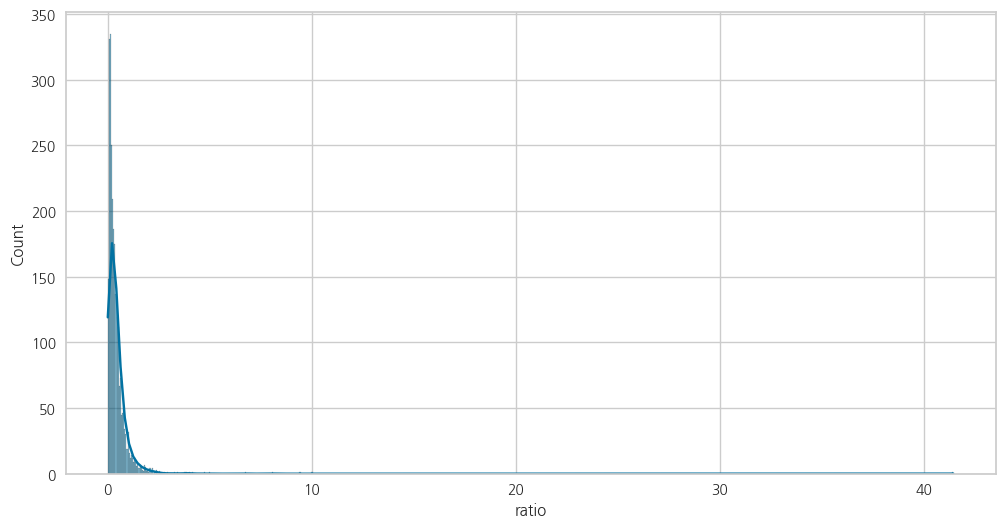

In [312]:
plt.figure(figsize=(12, 6))
sns.histplot(cluster_1['ratio'], kde=True)

### 이상치 탐지

{'whiskers': [<matplotlib.lines.Line2D at 0x20becbbd520>,
 'caps': [<matplotlib.lines.Line2D at 0x20becbbdaf0>,
 'boxes': [<matplotlib.lines.Line2D at 0x20becbbd250>],
 'medians': [<matplotlib.lines.Line2D at 0x20becbbe090>],
 'fliers': [<matplotlib.lines.Line2D at 0x20becbbe390>],
 'means': []}

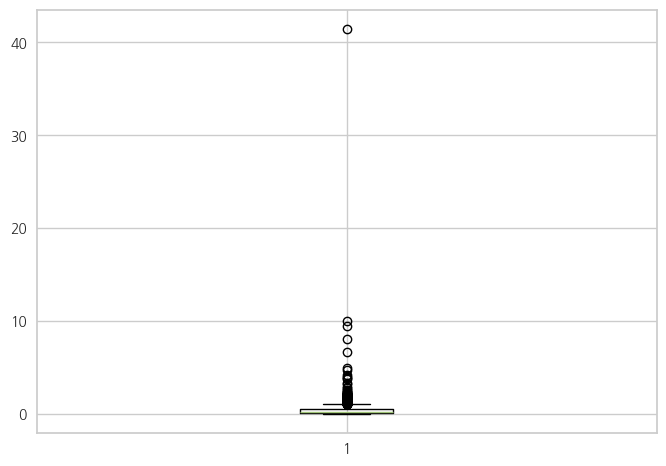

In [313]:
plt.boxplot(cluster_1['ratio'])

<Axes: xlabel='ratio', ylabel='Count'>

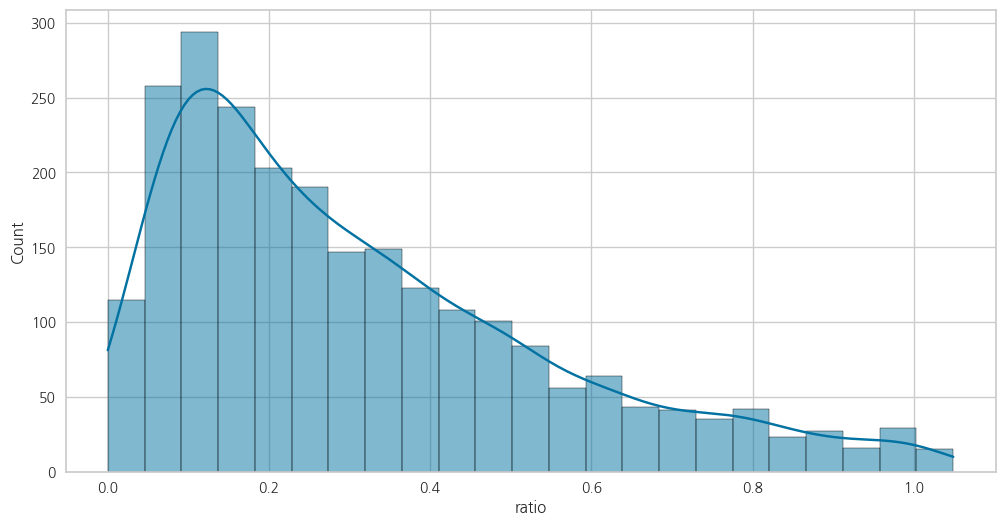

In [314]:
#박스플롯 기준 이상치 탐지
def find_outliers_iqr(data_series):
    Q1 = data_series.quantile(0.25)
    Q3 = data_series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data_series < lower_bound) | (data_series > upper_bound)

is_outlier = cluster_1[['ratio']].apply(find_outliers_iqr)

cluster_1_box = cluster_1[~is_outlier['ratio']].copy()
plt.figure(figsize=(12, 6))
sns.histplot(cluster_1_box['ratio'], kde=True)

사실 2주차 까지와 2주차 ~ 상영종료일까지의 간격은 클수밖에 없다. 따라서 박스플롯으로 이상치 제거는 하지 않는것이 좋을 것 같다 (이상치같지만 이상치가 아니다)

In [315]:
cluster_1['ratio'].describe()

count    2568.000000
mean        0.422740
std         0.971192
min         0.000000
25%         0.132043
50%         0.270109
75%         0.499638
max        41.441601
Name: ratio, dtype: float64

### 영화 흥행 유형

백분위수를 통해 구분한다

In [316]:
# 33, 66 백분위수 계산
p33 = cluster_1['ratio'].quantile(0.33)
p66 = cluster_1['ratio'].quantile(0.66)

print(f"33백분위수 (하위 그룹 경계): {p33:.2f}")
print(f"66백분위수 (상위 그룹 경계): {p66:.2f}")

33백분위수 (하위 그룹 경계): 0.17
66백분위수 (상위 그룹 경계): 0.40


In [317]:
percentile_lt = (cluster_1['ratio'] < 1).mean() * 100
print(f"ratio < 1인 경우 백분위수: {percentile_lt:.2f}")

ratio < 1인 경우 백분위수: 93.03


1. 초반 폭발형 : 66분위수보다 아래
2. 중반 균형형 : 66분위수 ~ ratio < 1
4. 후반 입소문형 : ratio >= 1

In [318]:
def classify_ratio(ratio):
    if ratio < p66:
        return '초반 폭발형'
    elif p66 <= ratio < 1:
        return '중반 균형형'
    else:
        return '후반 입소문형'

cluster_1['hit_category'] = cluster_1['ratio'].apply(classify_ratio)

In [319]:
cluster_1.tail()

,wk1_wk2,wk2_total,ratio,hit_category
2563,133.77,78.29,0.585258,중반 균형형
2564,12.47,22.57,1.809944,후반 입소문형
2565,58.13,12.23,0.210391,초반 폭발형
2566,107.95,122.33,1.133210,후반 입소문형
2567,65.57,23.64,0.360531,초반 폭발형


원핫인코딩

In [320]:
temp = cluster_1[["hit_category"]].copy()
temp = pd.get_dummies(temp, columns=["hit_category"], drop_first=True)
one_hot_cols = [col for col in temp.columns if col.startswith("hit_category_")]
temp[one_hot_cols] = temp[one_hot_cols].astype("int8")
temp.tail()

,hit_category_초반 폭발형,hit_category_후반 입소문형
2563,0,0
2564,0,1
2565,1,0
2566,0,1
2567,1,0


In [321]:
data_full = pd.concat([data_full, temp], axis=1)

In [322]:
data_full.head()

,Movie_Title,Total_Audience_Count,Total_Weeks,wk1_Audience,wk1_AudiencePerShow,wk2_Audience,wk2_AudiencePerShow,Show_Change,opening_Ho_Retention,wk1_Holiday_AudienceMean,wk1_Holiday_ShowMean,wk2_Holiday_AudienceMean,wk2_Holiday_ShowMean,opening_AudienceStd,Year,Month,Pandemic,dist_big_flop,dist_big_hit,dist_small_flop,dist_small_hit,Grade_15세이상관람가,Grade_전체관람가,Grade_청소년관람불가,Main_Country_미국,Main_Country_일본,Main_Country_한국,드라마,멜로/로맨스,다큐멘터리,공연,공포(호러),액션,애니메이션,코미디,스릴러,SF,미스터리,어드벤처,범죄,판타지,전쟁,가족,사극,뮤지컬,hit_category_초반 폭발형,hit_category_후반 입소문형
0,도쿄 리벤저스,13122,8,8617.0,5.654199,2925,5.034423,0.381234,0.130780,1762.500000,288.00,230.500000,18.500000,786.574025,2022,1,1,0.0,1.0,0.0,0.0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,매직브러시,169106,8,145560.0,37.670807,18117,14.717303,0.318582,0.182869,33644.250000,835.75,6152.500000,207.000000,19587.819778,2016,5,0,1.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,숨바꼭질,656089,8,195760.0,92.645528,307980,65.807692,2.214860,0.892172,72350.000000,708.00,64548.666667,689.333333,21173.653550,2005,2,0,0.0,1.0,0.0,0.0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
3,해빙,1201576,9,906864.0,44.818820,232306,13.362439,0.859197,0.189943,242744.333333,4170.00,46107.500000,1973.500000,106514.990773,2017,3,0,0.0,1.0,0.0,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,"다시, 봄",25506,4,18609.0,5.126446,3969,3.598368,0.303857,0.028099,3897.000000,656.00,109.500000,9.500000,1733.336745,2019,4,0,0.0,1.0,0.0,0.0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


# 2. FA

hit_category제외 나머지 변수로 FA분석 진행한다  
이를 토대로 어떤 요인이 초기 흥행력, 지속 흥행력이 있는지 등을 파악하기를 기대한다

In [323]:
print(list(data_no_dummies.columns))

['Movie_Title', 'Total_Audience_Count', 'Total_Weeks', 'wk1_Audience', 'wk1_AudiencePerShow', 'wk2_Audience', 'wk2_AudiencePerShow', 'Show_Change', 'opening_Ho_Retention', 'wk1_Holiday_AudienceMean', 'wk1_Holiday_ShowMean', 'wk2_Holiday_AudienceMean', 'wk2_Holiday_ShowMean', 'opening_AudienceStd', 'Year', 'Month', 'Pandemic', 'dist_big_flop', 'dist_big_hit', 'dist_small_flop', 'dist_small_hit', 'Grade', 'Main_Country']


In [324]:
fa_data = pd.concat([data_no_dummies[['wk1_Audience', 'wk1_AudiencePerShow', 'wk2_Audience', 'wk2_AudiencePerShow',
                       'Show_Change', 'opening_Ho_Retention', 'wk1_Holiday_AudienceMean', 'wk1_Holiday_ShowMean', 
                       'wk2_Holiday_AudienceMean', 'wk2_Holiday_ShowMean', 'opening_AudienceStd', 
                       'Year', 'Month', 'Pandemic', 
                       'dist_big_flop', 'dist_big_hit', 'dist_small_flop', 'dist_small_hit', 
                       'Grade', 'Main_Country']].copy(),
                       cluster_1[["hit_category"]]], axis=1)


In [325]:
# #문자를 숫자로 매핑
# for col in ["Grade", "Main_Country", "hit_category"]:
#     fa_data[col] = fa_data[col].astype("category").cat.codes

# fa_data.head()

In [326]:
hit_category = fa_data["hit_category"].copy()
fa_data = fa_data.drop(columns="hit_category").copy()

## month sin, cos 변환

In [327]:
fa_data['Month_sin'] = np.sin(2 * np.pi * fa_data['Month'] / 12)
fa_data['Month_cos'] = np.cos(2 * np.pi * fa_data['Month'] / 12)
fa_data.drop(columns=["Month"], inplace=True)

## FA분석 진행

### 표준화

In [328]:
#연속형 변수
num_cols = ['wk1_Audience', 'wk1_AudiencePerShow', 'wk2_Audience', 'wk2_AudiencePerShow',
            'Show_Change', 'opening_Ho_Retention', 'wk1_Holiday_AudienceMean', 'wk1_Holiday_ShowMean', 
            'wk2_Holiday_AudienceMean', 'wk2_Holiday_ShowMean', 'opening_AudienceStd', 
            'Year', 'Month_sin', 'Month_cos',
            'dist_big_flop', 'dist_big_hit', 'dist_small_flop', 'dist_small_hit']
#범주형 변수
cat_cols = ['Pandemic', 'Grade', 'Main_Country']

In [329]:
scaler = StandardScaler()
scale_data = fa_data[num_cols].copy() #범주형 변수는 사용하지 않는다
scale_data.loc[:, num_cols] = scaler.fit_transform(scale_data[num_cols])

C:\Users\swoo6\AppData\Local\Temp\ipykernel_3100\2368010926.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.54759764 -0.49084792  0.59193537 ... -0.5250016  -0.54239782
 -0.39428524]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  scale_data.loc[:, num_cols] = scaler.fit_transform(scale_data[num_cols])
C:\Users\swoo6\AppData\Local\Temp\ipykernel_3100\2368010926.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.1582566   0.16640323 -1.65199462 ...  1.48887439 -0.66014125
 -1.48668572]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  scale_data.loc[:, num_cols] = scaler.fit_transform(scale_data[num_cols])


In [330]:
scale_data.head()

,wk1_Audience,wk1_AudiencePerShow,wk2_Audience,wk2_AudiencePerShow,Show_Change,opening_Ho_Retention,wk1_Holiday_AudienceMean,wk1_Holiday_ShowMean,wk2_Holiday_AudienceMean,wk2_Holiday_ShowMean,opening_AudienceStd,Year,Month_sin,Month_cos,dist_big_flop,dist_big_hit,dist_small_flop,dist_small_hit
0,-0.563598,-0.921095,-0.547598,-0.824617,-1.224733,-0.828231,-0.590495,-0.619571,-0.519454,-0.605535,-0.589323,1.158257,0.645652,1.193307,-0.574346,0.538789,-0.259658,-0.318565
1,-0.143298,0.342888,-0.490848,-0.306617,-1.347320,-0.693466,-0.249586,-0.272603,-0.420322,-0.439482,0.057807,0.166403,0.645652,-1.301391,1.371459,-1.308489,-0.259658,-0.318565
2,0.010774,2.513236,0.591935,2.426543,2.363011,1.141642,0.164291,-0.353525,0.557206,-0.014585,0.112391,-1.651995,1.155591,0.666115,-0.574346,0.538789,-0.259658,-0.318565
3,2.193266,0.625085,0.309255,-0.379097,-0.289531,-0.675166,1.986303,1.839448,0.248509,1.116664,3.049802,0.331712,1.342241,-0.054042,-0.574346,0.538789,-0.259658,-0.318565
4,-0.532931,-0.941931,-0.543698,-0.901442,-1.376132,-1.093889,-0.567671,-0.386464,-0.521479,-0.613463,-0.556736,0.662330,1.155591,-0.774199,-0.574346,0.538789,-0.259658,-0.318565


### 요인 분석 적합 검사

In [331]:
# 1. Bartlett's Test
chi_square_value, p_value = calculate_bartlett_sphericity(scale_data)
print(f"Bartlett's test chi-square: {chi_square_value}, p-value: {p_value}")

# 2. KMO 검사
kmo_all, kmo_model = calculate_kmo(scale_data)
print(f"KMO: {kmo_model}")

Bartlett's test chi-square: 55153.87608407717, p-value: 0.0
KMO: 0.7740694644407824


C:\Users\swoo6\AppData\Roaming\Python\Python312\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


요인분석은 적합하다

### 요인 개수

In [332]:
#FA모델 생성
fa = FactorAnalyzer(n_factors=scale_data.shape[1], rotation=None) #변수의 길이만큼의 요인
fa.fit(scale_data)

ev, v = fa.get_eigenvalues() #고유값
#고유값 1 이상인 요인 개수 출력
eigenvalues_over_1 = ev[ev >= 1]
print(f"요인 고유값이 1 이상인 개수: {len(eigenvalues_over_1)}개")
print("고유값 1 이상인 목록:")
print(eigenvalues_over_1)

요인 고유값이 1 이상인 개수: 5개
고유값 1 이상인 목록:
[7.1639733  2.60903934 1.53634988 1.10045202 1.03073911]


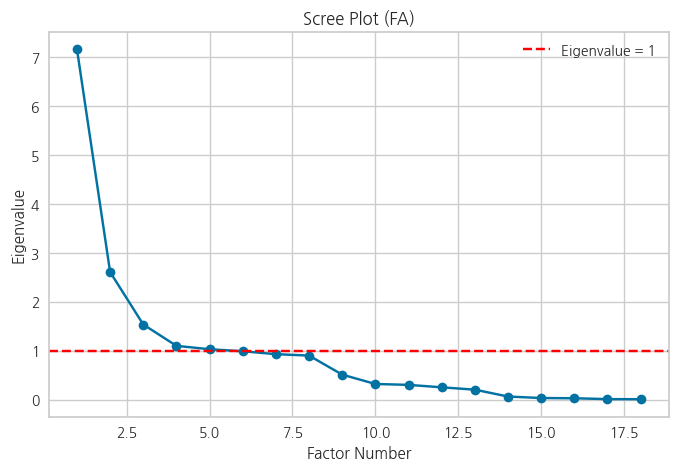

In [333]:
#Scree Plot으로도 확인
plt.figure(figsize=(8,5))
plt.plot(range(1, len(ev)+1), ev, marker='o')
plt.axhline(y=1, color='red', linestyle='--', label='Eigenvalue = 1')
plt.title('Scree Plot (FA)')
plt.xlabel('Factor Number')
plt.ylabel('Eigenvalue')
plt.legend()
plt.grid(True)
plt.show()

In [334]:
# 누적 설명 분산 출력
total_variance = np.cumsum(fa.get_factor_variance()[1])
print("누적 설명 분산:", total_variance)

누적 설명 분산: [0.39659737 0.53496084 0.6087424  0.65272236 0.68406169 0.70500754
 0.72307163 0.73740074 0.74718176 0.7525755  0.75630678 0.75846505
 0.75993783 0.76087768 0.7613755  0.76155665 0.76165603 0.76165603]


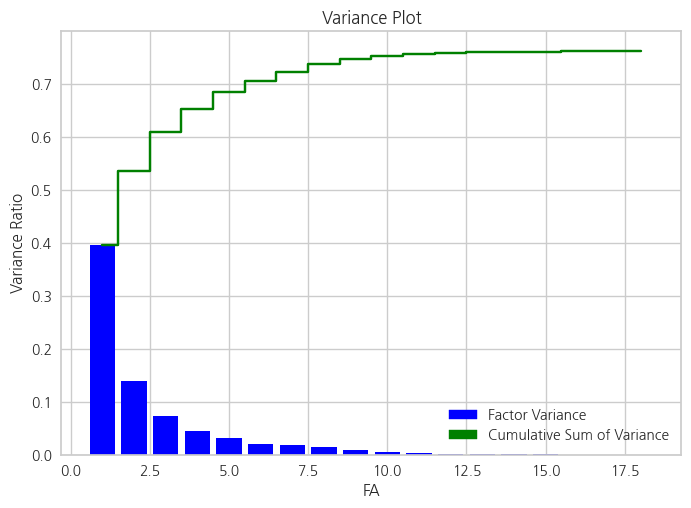

In [335]:
# Scree plot 그리기
x_axis = range(1, len(ev)+1)
plt.bar(x_axis, fa.get_factor_variance()[1], align='center', color="blue")
plt.step(x_axis, np.cumsum(fa.get_factor_variance()[1]), where = 'mid', color='green')
plt.xlabel('FA')
plt.ylabel('Variance Ratio')
plt.title('Variance Plot')
blue_patch = mpatches.Patch(color='blue', label='Factor Variance')
green_line = mpatches.Patch(color='green', label='Cumulative Sum of Variance')
plt.legend(handles=[blue_patch, green_line], loc='best')
plt.show()

요인 5개를 사용해도 누적설명분산이 0.7도 넘지 못한다 -> 각 요인끼리 구분은 명확하지만 설명력이 떨어진다

### 요인 회전

설명력이 떨어지더라도 요인 개수 7개를 사용해본다

요인상관행렬 : 
[[ 1.          0.30098852  0.24304121  0.16628841 -0.04258062]
 [ 0.30098852  1.          0.11852878  0.39203231  0.0919557 ]
 [ 0.24304121  0.11852878  1.          0.10648772  0.31422768]
 [ 0.16628841  0.39203231  0.10648772  1.          0.2046433 ]
 [-0.04258062  0.0919557   0.31422768  0.2046433   1.        ]]


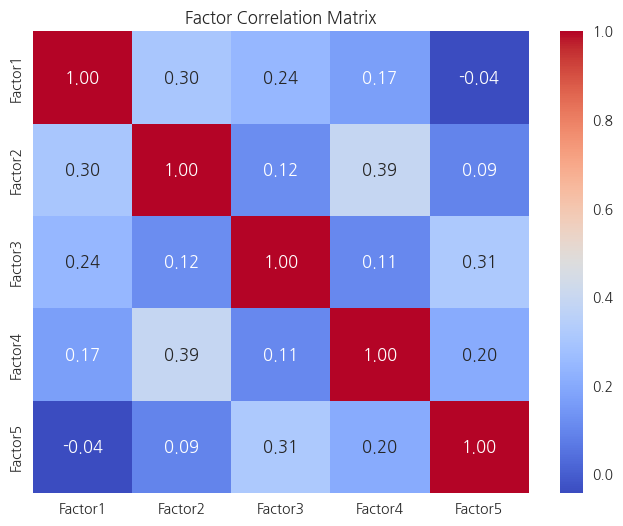

In [336]:
#요인 개수
fa_num=5
fa = FactorAnalyzer(n_factors=fa_num, rotation='promax')
fa.fit(scale_data)

print("요인상관행렬 : ")
print(fa.phi_)
# 요인 상관 행렬 히트맵
plt.figure(figsize=(8, 6))
sns.heatmap(fa.phi_, annot=True, cmap="coolwarm", fmt=".2f", cbar=True, xticklabels=[f"Factor{i+1}" for i in range(fa.phi_.shape[0])], yticklabels=[f"Factor{i+1}" for i in range(fa.phi_.shape[0])])
plt.title("Factor Correlation Matrix")
plt.show()

요인간에 상관이 존재한다 -> 요인간 서로 독립이라는 가정의 varimax는 사용하지 못한다

### 요인 로딩

In [337]:
#요인 로딩(factor loadings)
loadings = fa.loadings_

loadings_df = pd.DataFrame(loadings, 
                           index=scale_data.columns, 
                           columns=[f"Factor{i+1}" for i in range(loadings.shape[1])])

In [338]:
fa_n=10 #상위 몇개?
for factor in loadings_df.columns:
    print(f"===== {factor} =====")
    print(loadings_df[factor].sort_values(key=np.abs, ascending=False).head(fa_n)) #N-top
    print()

===== Factor1 =====
wk1_Holiday_AudienceMean    0.961355
wk1_Audience                0.956893
opening_AudienceStd         0.944308
wk2_Holiday_ShowMean        0.913871
wk1_Holiday_ShowMean        0.895031
wk2_Audience                0.875015
wk2_Holiday_AudienceMean    0.867408
wk1_AudiencePerShow         0.225155
Year                        0.200200
wk2_AudiencePerShow         0.156430
Name: Factor1, dtype: float64

===== Factor2 =====
wk1_AudiencePerShow         0.874961
wk2_AudiencePerShow         0.718499
Year                       -0.687944
Show_Change                 0.379791
wk1_Holiday_ShowMean       -0.343910
wk2_Holiday_ShowMean       -0.288222
wk2_Audience                0.098669
wk1_Holiday_AudienceMean    0.082293
wk2_Holiday_AudienceMean    0.081910
dist_big_hit                0.073882
Name: Factor2, dtype: float64

===== Factor3 =====
dist_big_hit                1.062750
dist_big_flop              -0.582988
dist_small_hit             -0.201522
dist_small_flop            

In [339]:
# 변수별로 가장 절대값 큰 Factor 하나만 배정
best_factor_assignment = {}

for var in loadings_df.index:
    best_factor = loadings_df.loc[var].abs().idxmax()  # 가장 큰 절대값 로딩을 가진 Factor
    best_factor_assignment[var] = best_factor

# Factor별로 모으기
final_strong_loadings = {factor: [] for factor in loadings_df.columns}
for var, factor in best_factor_assignment.items():
    if abs(loadings_df.loc[var, factor]) >= 0.4:  # 여전히 로딩이 0.4 이상인 것만
        final_strong_loadings[factor].append(var)

for i in range(1, len(final_strong_loadings)+1):
    print(loadings_df.loc[final_strong_loadings[f"Factor{i}"], [f"Factor{i}"]].sort_values(by=f"Factor{i}", ascending=False), "\n")


                           Factor1
wk1_Holiday_AudienceMean  0.961355
wk1_Audience              0.956893
opening_AudienceStd       0.944308
wk2_Holiday_ShowMean      0.913871
wk1_Holiday_ShowMean      0.895031
wk2_Audience              0.875015
wk2_Holiday_AudienceMean  0.867408 

                      Factor2
wk1_AudiencePerShow  0.874961
wk2_AudiencePerShow  0.718499
Year                -0.687944 

                Factor3
dist_big_hit   1.062750
dist_big_flop -0.582988 

                       Factor4
opening_Ho_Retention  0.936994
Show_Change           0.529382 

                 Factor5
dist_small_hit  0.667211 



In [340]:
threshold = 0.40 # 교차 허용 주성분 점수 임계값
load_abs  = loadings_df.abs() # 주성분 점수의 절댓값

# 임계값 이상인 것만 추출
mask = load_abs >= threshold 

#그룹핑
multi_groups_fa = {
    fa_f: mask.index[mask[fa_f]].tolist()
    for fa_f in loadings_df.columns
}

for i in range(1, len(multi_groups_fa)+1):
    print(loadings_df.loc[multi_groups_fa[f"Factor{i}"], [f"Factor{i}"]].sort_values(by=f"Factor{i}", ascending=False), "\n")

                           Factor1
wk1_Holiday_AudienceMean  0.961355
wk1_Audience              0.956893
opening_AudienceStd       0.944308
wk2_Holiday_ShowMean      0.913871
wk1_Holiday_ShowMean      0.895031
wk2_Audience              0.875015
wk2_Holiday_AudienceMean  0.867408 

                      Factor2
wk1_AudiencePerShow  0.874961
wk2_AudiencePerShow  0.718499
Year                -0.687944 

                Factor3
dist_big_hit   1.062750
dist_big_flop -0.582988 

                       Factor4
opening_Ho_Retention  0.936994
Show_Change           0.529382 

                 Factor5
dist_small_hit  0.667211
dist_big_hit   -0.417947 



요인 1 : 영화의 규모를 나타내는 요소  
요인 2 : 상영 영화 효율, 시간이 지날수록 효율성이 감소한다  
요인 3 : 배급사 흥행력 요인, 독립영화냐 메이저 영화냐를 가를 수 있을 듯  
요인 4 : 2주차 흥행 유지 요인  
요인 5 : 배급사 규모 요인, 독립영화냐 메이저 영화냐를 가를 수 있을 듯

In [341]:
#Regression 점수
factor_scores_df = pd.DataFrame(
    fa.transform(scale_data),
    columns=[f"FA{i+1}" for i in range(fa.n_factors)],
    index=scale_data.index
)

# 3. 집단간 차이 분석

FA분석 결과를 사용  
hit_category 집단간 차이가 있는지 검정한다  

1. 연속형 변수 : ANOVA
2. 비정규성 연속형 변수 : Kruskal–Wallis 비모수 검정
3. 범주형 변수 : 카이제곱 검정

Shapiro-Wilk test / Levene test : 정규성, 등분산성 확인 (연속형)  
Post-hoc test (Tukey HSD) : 어떤 집단 간 차이가 유의한지 구체적으로 확인

In [342]:
data_class_diff = pd.concat([factor_scores_df, fa_data[cat_cols], hit_category], axis=1)
data_class_diff.head()

,FA1,FA2,FA3,FA4,FA5,Pandemic,Grade,Main_Country,hit_category
0,-0.581703,-0.873621,0.334321,-0.860584,-0.302076,1,15세이상관람가,일본,중반 균형형
1,-0.235392,0.273776,-1.353467,-0.748044,-0.342353,0,전체관람가,기타,초반 폭발형
2,0.103283,2.615669,0.523378,1.502512,0.556472,0,15세이상관람가,미국,초반 폭발형
3,1.734376,-0.007841,0.617193,-1.091703,-0.357989,0,15세이상관람가,한국,초반 폭발형
4,-0.598004,-0.887915,0.400546,-1.055799,-0.290591,0,12세이상관람가,한국,중반 균형형


## 요인 점수

### 정규성, 등분산성 검정

귀무가설 : 모든 집단에서 정규분포를 만족한다

In [343]:
for col in factor_scores_df.columns:
    print(f"\n[{col}]")
    for cat in sorted(data_class_diff['hit_category'].unique()):
        group = data_class_diff[data_class_diff['hit_category'] == cat][col]
        stat, p = shapiro(group)
        print(f"  hit_category={cat} → 통계량={stat:.4f}, p-value={p:.4f}")


[FA1]
  hit_category=중반 균형형 → 통계량=0.7259, p-value=0.0000
  hit_category=초반 폭발형 → 통계량=0.6192, p-value=0.0000
  hit_category=후반 입소문형 → 통계량=0.5611, p-value=0.0000

[FA2]
  hit_category=중반 균형형 → 통계량=0.8808, p-value=0.0000
  hit_category=초반 폭발형 → 통계량=0.8331, p-value=0.0000
  hit_category=후반 입소문형 → 통계량=0.7588, p-value=0.0000

[FA3]
  hit_category=중반 균형형 → 통계량=0.8751, p-value=0.0000
  hit_category=초반 폭발형 → 통계량=0.8168, p-value=0.0000
  hit_category=후반 입소문형 → 통계량=0.8243, p-value=0.0000

[FA4]
  hit_category=중반 균형형 → 통계량=0.7398, p-value=0.0000
  hit_category=초반 폭발형 → 통계량=0.8555, p-value=0.0000
  hit_category=후반 입소문형 → 통계량=0.9041, p-value=0.0000

[FA5]
  hit_category=중반 균형형 → 통계량=0.8279, p-value=0.0000
  hit_category=초반 폭발형 → 통계량=0.8210, p-value=0.0000
  hit_category=후반 입소문형 → 통계량=0.8137, p-value=0.0000


귀무 가설 : 모든 집단에서 등분산성을 만족한다

In [344]:
for col in factor_scores_df.columns:
    group1 = data_class_diff[data_class_diff['hit_category'] == '중반 균형형'][col]
    group2 = data_class_diff[data_class_diff['hit_category'] == '초반 폭발형'][col]
    group3 = data_class_diff[data_class_diff['hit_category'] == '후반 입소문형'][col]
    
    stat, p = levene(group1, group2, group3)
    print(f"{col} 등분산성 검정: 통계량={stat:.4f}, p-value={p:.4f}")

FA1 등분산성 검정: 통계량=34.0114, p-value=0.0000
FA2 등분산성 검정: 통계량=40.7706, p-value=0.0000
FA3 등분산성 검정: 통계량=34.1274, p-value=0.0000
FA4 등분산성 검정: 통계량=10.8764, p-value=0.0000
FA5 등분산성 검정: 통계량=10.2876, p-value=0.0000


정규성, 등분산성 가설 검정이 모두 깨졌다.  
따라서 비모수 검정: Kruskal-Wallis test 이후, 이것이 유의하다면 사후 검정 (Post-hoc test)을 진행

### Kruskal-Wallis

귀무가설 : 모든 집단의 중앙값이 동일하다

In [345]:
for col in factor_scores_df.columns:
    groups = [data_class_diff.loc[data_class_diff['hit_category'] == cat, col]
              for cat in sorted(data_class_diff['hit_category'].unique())]
    
    stat, p = kruskal(*groups)
    print(f"{col} Kruskal-Wallis: stat={stat:.4f}, p-value={p:.4f}")

FA1 Kruskal-Wallis: stat=26.5986, p-value=0.0000
FA2 Kruskal-Wallis: stat=28.3888, p-value=0.0000
FA3 Kruskal-Wallis: stat=131.6392, p-value=0.0000
FA4 Kruskal-Wallis: stat=360.5768, p-value=0.0000
FA5 Kruskal-Wallis: stat=20.2034, p-value=0.0000


귀무가설 폐지, 모든 집단간 유의한 차이가 있다

### 사후 검정

pairwise Dunn test (비모수 사후검정)

어떤 집단간 차이가 존재하는지 확인

In [346]:
for col in factor_scores_df.columns:
    result = sp.posthoc_dunn(
        data_class_diff, 
        val_col=col, 
        group_col='hit_category', 
        p_adjust='bonferroni'
    )
    print(f"\n[{col}] Dunn 사후검정 (Bonferroni 보정):\n", result)


[FA1] Dunn 사후검정 (Bonferroni 보정):
                중반 균형형    초반 폭발형       후반 입소문형
중반 균형형   1.000000e+00  0.091978  7.689798e-07
초반 폭발형   9.197754e-02  1.000000  6.212437e-05
후반 입소문형  7.689798e-07  0.000062  1.000000e+00

[FA2] Dunn 사후검정 (Bonferroni 보정):
                중반 균형형        초반 폭발형   후반 입소문형
중반 균형형   1.000000e+00  3.350306e-07  0.340907
초반 폭발형   3.350306e-07  1.000000e+00  0.525893
후반 입소문형  3.409075e-01  5.258930e-01  1.000000

[FA3] Dunn 사후검정 (Bonferroni 보정):
                중반 균형형        초반 폭발형       후반 입소문형
중반 균형형   1.000000e+00  2.933372e-12  6.971105e-08
초반 폭발형   2.933372e-12  1.000000e+00  2.787098e-23
후반 입소문형  6.971105e-08  2.787098e-23  1.000000e+00

[FA4] Dunn 사후검정 (Bonferroni 보정):
                중반 균형형        초반 폭발형       후반 입소문형
중반 균형형   1.000000e+00  8.311199e-66  1.000000e+00
초반 폭발형   8.311199e-66  1.000000e+00  9.951531e-27
후반 입소문형  1.000000e+00  9.951531e-27  1.000000e+00

[FA5] Dunn 사후검정 (Bonferroni 보정):
            중반 균형형    초반 폭발형  후반 입소문형
중반 균형형   1.000000  0

### 결론

주요한 해석만 기입  

- FA1 : 초반 흥행 규모 요인  
초반과 중반에서는 FA1의 분포에 대해 유의미한 차이는 없지만, 후반은 초반, 중반과 유의미한 차이를 보였다  
-> 후반 입소문형은 초반 흥행 규모적인 측면에서 차이가 있을 것이다 (관객수가 낮을 것으로 예상)

- FA3 : 배급사 흥행력 요인, 같은 대형 배급사여도 흥행이 다르다  
이것은 모든 영화 흥행 유형 집단에서 FA3의 분포에 서로 차이가 있다  
-> 메이저 영화, 독립영화(흥행이 안된), 하꼬영화냐에 따라 영화 흥행 유형이 달라질 것으로 기대된다

- FA4 : 2주차 흥행 유지력 요인  
FA4의 분포에 대하여 영화 흥행 유형이 초반인 것이 중반과 후반과 차이가 있다. 또한 중반과 후반은 FA4의 분포에 차이가 없다  
-> 유형이 초반인 것만 독립적인 분포를 보인다  
-> 증반과 후반 입소문형은 초기주차(2주차)까지의 흥행 유지력은 비슷하다  
-> 즉 둘 모두 1주차에서 2주차로 넘어갈 때 관객수가 빠지거나, 관객수가 늘거나 둘 중 하나로 동일하다  
-> 중반과 후반이 구분지어지는 구간은 3주차 그 이후에 관객이 급감하냐 유지되냐로 볼 수 있다



Cliff’s δ(델타) : 비모수 효과크기  
- “두 집단 간 값이 실제로 어느 쪽이 더 큰 경향이 있는가?”
- “그 차이가 얼마나 일관적으로 나타나는가?”  

a > b → +1  
a < b → -1  
a = b → 0  
이 모든값을 평균낸것이 시그마


[FA1] 요약 ----------------------
              count  median   mean    std    min    max    p25    p75
hit_category                                                         
초반 폭발형         1695  -0.440 -0.075  0.884 -0.777  6.899 -0.538 -0.009
중반 균형형          694  -0.446  0.241  1.237 -0.780  5.487 -0.546  0.665
후반 입소문형         179  -0.515 -0.224  0.775 -1.228  5.053 -0.561 -0.381
Median test p=5.066e-07, 전체 중앙값=-0.44919547245412345

쌍별 Cliff’s δ (앞집단>뒷집단 이면 +):
  중반 균형형 vs 초반 폭발형 : δ=0.059
  중반 균형형 vs 후반 입소문형 : δ=0.222
  초반 폭발형 vs 후반 입소문형 : δ=0.205


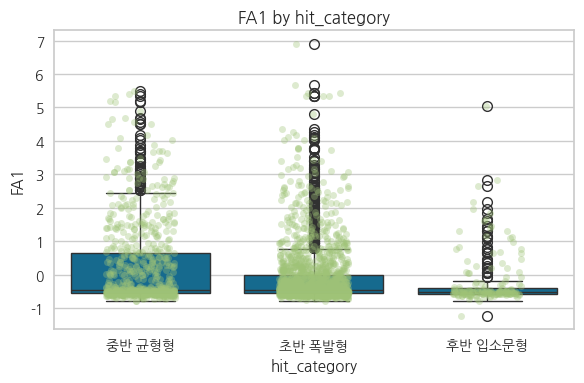


[FA2] 요약 ----------------------
              count  median   mean    std    min    max    p25    p75
hit_category                                                         
중반 균형형          694  -0.104  0.223  1.227 -2.576  6.171 -0.616  0.789
후반 입소문형         179  -0.268  0.024  1.042 -1.783  6.457 -0.600  0.253
초반 폭발형         1695  -0.314 -0.094  0.835 -1.815  5.966 -0.661  0.217
Median test p=3.656e-05, 전체 중앙값=-0.26769011245858254

쌍별 Cliff’s δ (앞집단>뒷집단 이면 +):
  중반 균형형 vs 초반 폭발형 : δ=0.137
  중반 균형형 vs 후반 입소문형 : δ=0.082
  초반 폭발형 vs 후반 입소문형 : δ=-0.064


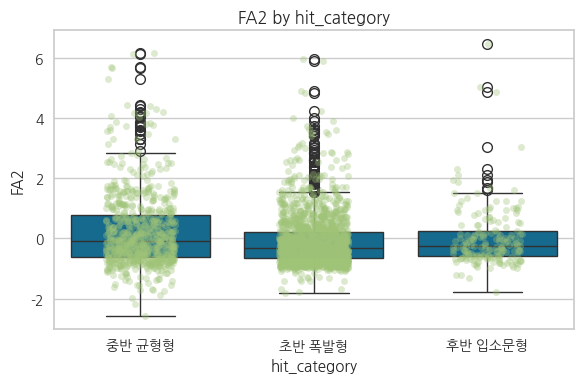


[FA3] 요약 ----------------------
              count  median   mean    std    min    max    p25    p75
hit_category                                                         
초반 폭발형         1695   0.427  0.101  0.885 -2.063  5.170 -0.540  0.538
중반 균형형          694   0.324 -0.093  1.087 -1.651  4.277 -1.380  0.481
후반 입소문형         179  -1.194 -0.594  1.031 -1.780  3.828 -1.457  0.346
Median test p=1.454e-28, 전체 중앙값=0.3898125370034781

쌍별 Cliff’s δ (앞집단>뒷집단 이면 +):
  중반 균형형 vs 초반 폭발형 : δ=-0.186
  중반 균형형 vs 후반 입소문형 : δ=0.274
  초반 폭발형 vs 후반 입소문형 : δ=0.455


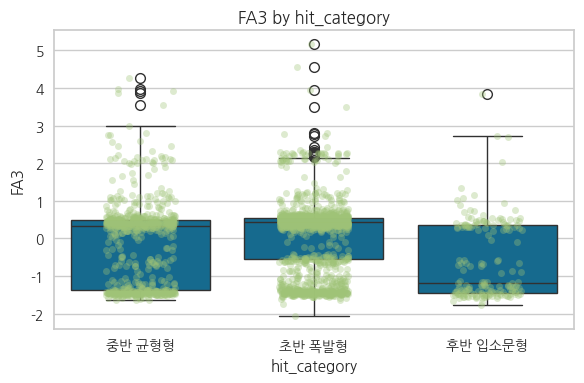


[FA4] 요약 ----------------------
              count  median   mean    std    min     max    p25    p75
hit_category                                                          
후반 입소문형         179   0.428  0.538  1.076 -1.220   5.580 -0.252  1.066
중반 균형형          694   0.312  0.407  1.057 -1.331  15.095 -0.209  0.865
초반 폭발형         1695  -0.409 -0.224  0.806 -2.603   9.545 -0.810  0.189
Median test p=9.193e-58, 전체 중앙값=-0.16417959212212574

쌍별 Cliff’s δ (앞집단>뒷집단 이면 +):
  중반 균형형 vs 초반 폭발형 : δ=0.451
  중반 균형형 vs 후반 입소문형 : δ=-0.074
  초반 폭발형 vs 후반 입소문형 : δ=-0.477


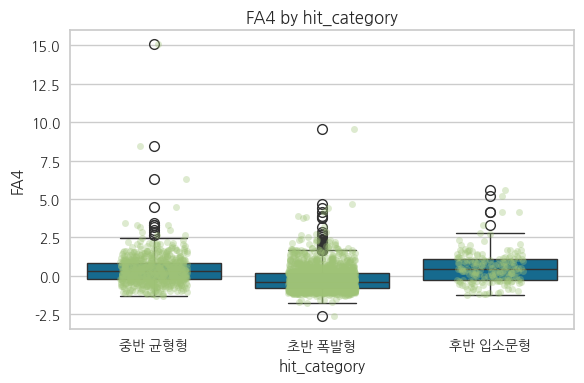


[FA5] 요약 ----------------------
              count  median   mean    std    min    max    p25    p75
hit_category                                                         
초반 폭발형         1695  -0.098  0.012  0.640 -2.008  4.651 -0.309  0.120
중반 균형형          694  -0.194 -0.025  0.800 -3.677  4.896 -0.448  0.123
후반 입소문형         179  -0.207 -0.015  0.826 -1.213  3.713 -0.475  0.071
Median test p=4.499e-06, 전체 중앙값=-0.1263309051742131

쌍별 Cliff’s δ (앞집단>뒷집단 이면 +):
  중반 균형형 vs 초반 폭발형 : δ=-0.100
  중반 균형형 vs 후반 입소문형 : δ=0.034
  초반 폭발형 vs 후반 입소문형 : δ=0.134


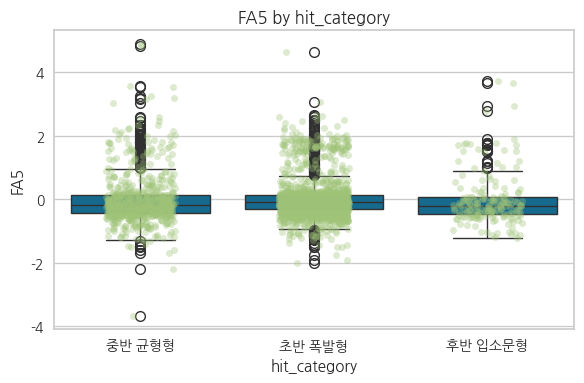

In [347]:
# -----------------------
# Cliff's Delta 정의
# -----------------------
def cliffs_delta(a, b):
    a = np.asarray(a); b = np.asarray(b)
    diff = np.subtract.outer(a, b)
    n = a.size * b.size
    return (np.sum(diff > 0) - np.sum(diff < 0)) / n  # >0이면 앞집단↑

# -----------------------
# 집단별 요약 + Cliff's δ + 박스플롯
# -----------------------
def summarize_factors_by_hit(df, group_col='hit_category', factor_cols=None):
    """
    hit_category별 각 요인 점수의 요약통계, 중앙값 검정, 효과크기, 시각화
    """
    if factor_cols is None:
        factor_cols = [c for c in df.columns if c.startswith('FA')]

    for y in factor_cols:
        print(f"\n[{y}] 요약 ----------------------")
        
        # 1) 요약통계
        summ = (df.groupby(group_col)[y]
                  .agg(['count','median','mean','std','min','max',
                        lambda s: np.percentile(s,25),
                        lambda s: np.percentile(s,75)])
                  .rename(columns={'<lambda_0>':'p25','<lambda_1>':'p75'})
                  .sort_values('median', ascending=False))
        print(summ.round(3))
        
        # 2) 중앙값 검정 (Kruskal-Wallis의 비모수 대안)
        groups = [g[y].values for _, g in df.groupby(group_col)]
        stat, p, med, tbl = median_test(*groups)
        print(f"Median test p={p:.4g}, 전체 중앙값={med}")
        
        # 3) Cliff’s δ (효과크기)
        levels = list(df[group_col].dropna().unique())
        print("\n쌍별 Cliff’s δ (앞집단>뒷집단 이면 +):")
        for i in range(len(levels)):
            for j in range(i+1, len(levels)):
                a = df.loc[df[group_col]==levels[i], y]
                b = df.loc[df[group_col]==levels[j], y]
                d = cliffs_delta(a, b)
                print(f"  {levels[i]} vs {levels[j]} : δ={d:.3f}")
        
        # 4) 시각화 (박스+점)
        plt.figure(figsize=(6,4))
        sns.boxplot(data=df, x=group_col, y=y, order=sorted(df[group_col].unique()))
        sns.stripplot(data=df, x=group_col, y=y, order=sorted(df[group_col].unique()),
                      alpha=0.35, jitter=0.2)
        plt.title(f'{y} by {group_col}')
        plt.tight_layout()
        plt.show()

# -----------------------
# 실행 예시
# -----------------------
summarize_factors_by_hit(data_class_diff, group_col='hit_category', factor_cols=factor_scores_df.columns)

# 4. 총 상영주차와 변수 유의성 검정

총 상영주차 예측을 위한 것  
hit category 변수를 생성하였으니 다시 진행해본다

In [348]:
data_week_diff = pd.concat([data_no_dummies[['Total_Weeks']], data_class_diff], axis=1)

In [349]:
data_week_diff.head()

,Total_Weeks,FA1,FA2,FA3,FA4,FA5,Pandemic,Grade,Main_Country,hit_category
0,8,-0.581703,-0.873621,0.334321,-0.860584,-0.302076,1,15세이상관람가,일본,중반 균형형
1,8,-0.235392,0.273776,-1.353467,-0.748044,-0.342353,0,전체관람가,기타,초반 폭발형
2,8,0.103283,2.615669,0.523378,1.502512,0.556472,0,15세이상관람가,미국,초반 폭발형
3,9,1.734376,-0.007841,0.617193,-1.091703,-0.357989,0,15세이상관람가,한국,초반 폭발형
4,4,-0.598004,-0.887915,0.400546,-1.055799,-0.290591,0,12세이상관람가,한국,중반 균형형


## 총 상영주차와 FA

### 1) 정규성 검정

귀무가설 : 모든 집단에서 정규분포를 만족한다

In [350]:
for col in ['Total_Weeks'] + [f'FA{i}' for i in range(1,6)]:
    stat, p = shapiro(data_week_diff[col])
    print(f"{col}: p={p:.4f}")

Total_Weeks: p=0.0000
FA1: p=0.0000
FA2: p=0.0000
FA3: p=0.0000
FA4: p=0.0000
FA5: p=0.0000


### 2) 상관분석

정규성을 만족하지 않으니 스피어만 상관계수로 변경

In [351]:
for col in [f'FA{i}' for i in range(1,6)]:
    rho, p = spearmanr(data_week_diff['Total_Weeks'], data_week_diff[col])
    method = 'spearmanr'
    print(f"{col} ↔ Total_Weeks ({method}) : rho={rho:.3f}, p={p:.4f}")


FA1 ↔ Total_Weeks (spearmanr) : rho=0.162, p=0.0000
FA2 ↔ Total_Weeks (spearmanr) : rho=0.059, p=0.0030
FA3 ↔ Total_Weeks (spearmanr) : rho=-0.115, p=0.0000
FA4 ↔ Total_Weeks (spearmanr) : rho=0.493, p=0.0000
FA5 ↔ Total_Weeks (spearmanr) : rho=-0.056, p=0.0049


### 결론

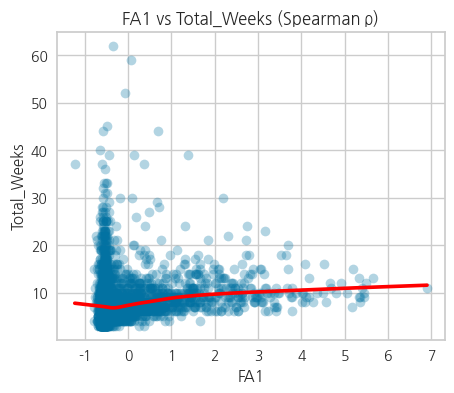

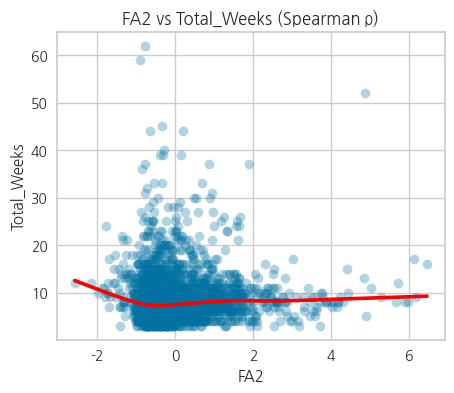

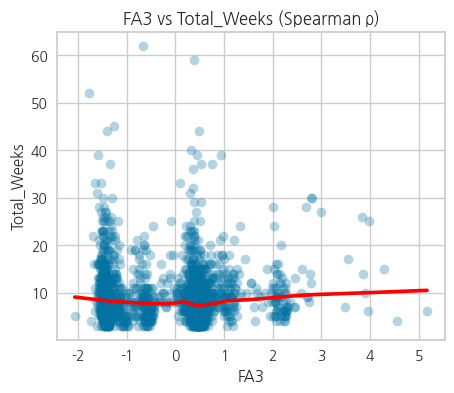

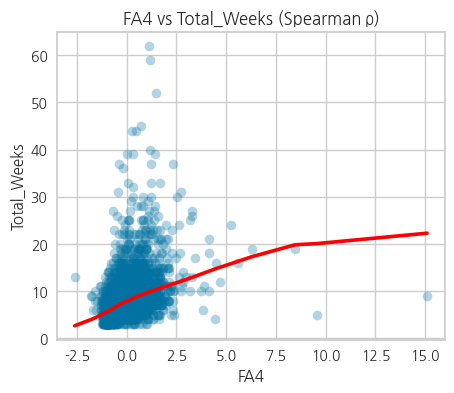

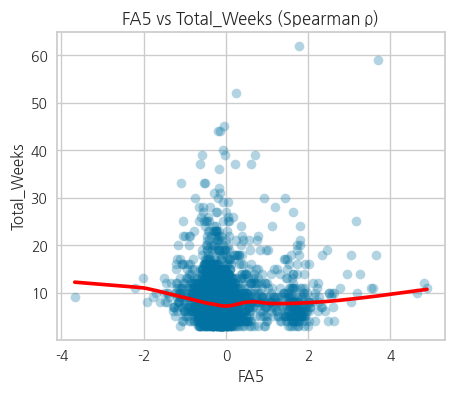

In [352]:
for col in [f'FA{i}' for i in range(1,6)]:
    plt.figure(figsize=(5,4))
    sns.regplot(x=data_week_diff[col], y=data_week_diff['Total_Weeks'],
                lowess=True, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
    plt.title(f"{col} vs Total_Weeks (Spearman ρ)")
    plt.show()

FA4(2주차 영화 흥행유지 요인)만이 총 상영주차와 상관이 있다 (영화의 규묘는 큰 관련이 없다)  
이거를 이용해 상영주차를 예측이든 결정하든 할 수 있을 것

## 총 상영주차와 범주형 변수

### 1) 각 그룹별 정규성 검정

귀무가설 : 모든 집단에서 정규분포를 만족한다

In [353]:
for col in ['Pandemic','Grade','Main_Country','hit_category']:
    print(f"\n[{col}] 그룹별 Shapiro 검정")
    for cat in sorted(data_class_diff[col].unique()):
        group = data_week_diff.loc[data_week_diff[col]==cat, 'Total_Weeks']
        stat, p = shapiro(group)
        print(f"  {col}={cat} → p={p:.4f}")


[Pandemic] 그룹별 Shapiro 검정
  Pandemic=0 → p=0.0000
  Pandemic=1 → p=0.0000
  Pandemic=2 → p=0.0000

[Grade] 그룹별 Shapiro 검정
  Grade=12세이상관람가 → p=0.0000
  Grade=15세이상관람가 → p=0.0000
  Grade=전체관람가 → p=0.0000
  Grade=청소년관람불가 → p=0.0000

[Main_Country] 그룹별 Shapiro 검정
  Main_Country=기타 → p=0.0000
  Main_Country=미국 → p=0.0000
  Main_Country=일본 → p=0.0000
  Main_Country=한국 → p=0.0000

[hit_category] 그룹별 Shapiro 검정
  hit_category=중반 균형형 → p=0.0000
  hit_category=초반 폭발형 → p=0.0000
  hit_category=후반 입소문형 → p=0.0000


### 2) 각 그룹별 등분산성 검정

귀무 가설 : 모든 집단에서 등분산성을 만족한다

In [354]:
for col in ['Pandemic','Grade','Main_Country','hit_category']:
    groups = [data_week_diff.loc[data_week_diff[col]==cat, 'Total_Weeks']
              for cat in sorted(data_week_diff[col].unique())]
    stat, p = levene(*groups)
    print(f"{col} 등분산성: p={p:.4f}")

Pandemic 등분산성: p=0.0002
Grade 등분산성: p=0.0000
Main_Country 등분산성: p=0.0000
hit_category 등분산성: p=0.0000


정규성, 등분산성 가설 검정이 모두 깨졌다.  
따라서 비모수 검정: Kruskal-Wallis test 이후, 이것이 유의하다면 사후 검정 (Post-hoc test)을 진행

### 3) Kruskal–Wallis

귀무가설 : 모든 집단의 중앙값이 동일하다

In [355]:
for col in ['Pandemic','Grade','Main_Country','hit_category']:
    groups = [data_week_diff.loc[data_week_diff[col]==cat, 'Total_Weeks']
              for cat in sorted(data_week_diff[col].unique())]
    stat, p = kruskal(*groups)
    print(f"{col} ↔ Total_Weeks (Kruskal): stat={stat:.3f}, p={p:.4f}")


Pandemic ↔ Total_Weeks (Kruskal): stat=62.027, p=0.0000
Grade ↔ Total_Weeks (Kruskal): stat=43.958, p=0.0000
Main_Country ↔ Total_Weeks (Kruskal): stat=38.300, p=0.0000
hit_category ↔ Total_Weeks (Kruskal): stat=925.237, p=0.0000


### 4) 사후검정

In [356]:
for col in ['Pandemic','Grade','Main_Country','hit_category']:
    result = sp.posthoc_dunn(
        data_week_diff, val_col='Total_Weeks', group_col=col, p_adjust='bonferroni'
    )
    print(f"\n[{col}] Dunn 사후검정 결과:\n", result)


[Pandemic] Dunn 사후검정 결과:
               0             1             2
0  1.000000e+00  7.743617e-07  9.242400e-11
1  7.743617e-07  1.000000e+00  3.226597e-01
2  9.242400e-11  3.226597e-01  1.000000e+00

[Grade] Dunn 사후검정 결과:
           12세이상관람가  15세이상관람가     전체관람가   청소년관람불가
12세이상관람가  1.000000  0.000008  1.000000  0.000005
15세이상관람가  0.000008  1.000000  0.000111  1.000000
전체관람가     1.000000  0.000111  1.000000  0.000033
청소년관람불가   0.000005  1.000000  0.000033  1.000000

[Main_Country] Dunn 사후검정 결과:
           기타            미국        일본            한국
기타  1.000000  1.366450e-01  0.057264  1.720270e-01
미국  0.136645  1.000000e+00  0.000072  3.945719e-07
일본  0.057264  7.183145e-05  1.000000  1.000000e+00
한국  0.172027  3.945719e-07  1.000000  1.000000e+00

[hit_category] Dunn 사후검정 결과:
                 중반 균형형         초반 폭발형       후반 입소문형
중반 균형형    1.000000e+00  8.913453e-144  1.356353e-07
초반 폭발형   8.913453e-144   1.000000e+00  6.685813e-93
후반 입소문형   1.356353e-07   6.685813e-93  1.000000e+00


### 결론

1. 팬데믹  
팬데믹 이전(0)만이 팬데믹 중(1)과 팬데믹 이후(2)와 총 상영주차의 분포가 다르다.  
팬데믹 중과 이후는 상영주차의 분포가 비슷하다  

2. 영화 등급  
총 상영주차의 분포는 전체와 12세, 15세와 청불이 서로 각각 분포의 차이가 없었다.  
나머지 분포끼리는 차이를 보인다  
따라서 저연령 등급과 고연령 등급 그룹간에 총 상영주차의 차이가 난다고 볼 수 있다.

3. 영화 대표 제작국가  
일본과 기타, 일본과 미국, 한국과 미국만이 서로 총 상영주차 분포에 차이가 난다  
즉 미국은 한국과 일본과 분포가 다르고, 또한 한국과 일본은 서로 상영주차의 분포에 차이가 없다고 할 수 있다  

4. 영화 흥행 유형  
초반, 중반, 후반 유형은 모두 총 상영주차의 분포가 서로 뚜렷하게 차이가 난다


[Pandemic] Total_Weeks 요약
           count  median    mean    std  min  max  p25    p75
Pandemic                                                    
2           288     9.0  10.319  5.993    3   39  6.0  12.00
1           368     8.0   9.766  6.419    3   62  6.0  11.25
0          1912     7.0   8.270  4.822    3   52  5.0  10.00
Median test p=2.396e-06, 전체 중앙값=7.0

쌍별 Cliff’s δ (앞집단>뒷집단 이면 +):
  1 vs 0 : δ=0.169
  1 vs 2 : δ=-0.072
  0 vs 2 : δ=-0.242


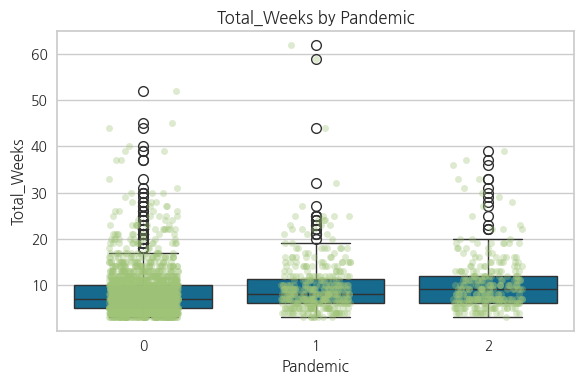


[Grade] Total_Weeks 요약
           count  median   mean    std  min  max  p25   p75
Grade                                                     
12세이상관람가    702     8.0  9.207  5.149    3   39  6.0  11.0
전체관람가       492     8.0  9.726  6.473    3   52  6.0  12.0
15세이상관람가    977     7.0  8.203  4.968    3   62  5.0  10.0
청소년관람불가     397     7.0  7.851  4.184    3   31  5.0  10.0
Median test p=3.448e-06, 전체 중앙값=7.0

쌍별 Cliff’s δ (앞집단>뒷집단 이면 +):
  15세이상관람가 vs 전체관람가 : δ=-0.135
  15세이상관람가 vs 12세이상관람가 : δ=-0.140
  15세이상관람가 vs 청소년관람불가 : δ=0.044
  전체관람가 vs 12세이상관람가 : δ=0.002
  전체관람가 vs 청소년관람불가 : δ=0.173
  12세이상관람가 vs 청소년관람불가 : δ=0.175


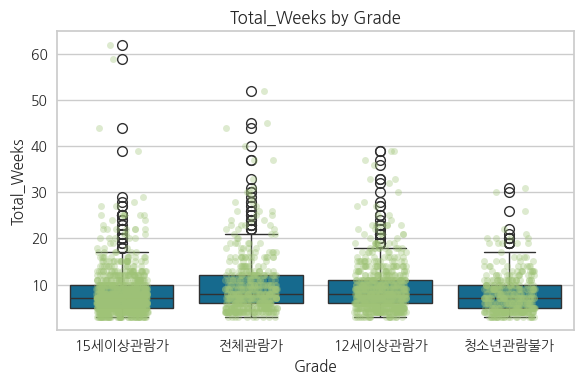


[Main_Country] Total_Weeks 요약
               count  median    mean    std  min  max  p25   p75
Main_Country                                                   
일본              188     8.0  10.452  7.551    3   59  6.0  12.0
한국              899     8.0   8.980  4.912    3   45  6.0  11.0
기타              489     7.0   8.824  5.596    3   52  5.0  11.0
미국              992     7.0   8.091  4.792    3   62  5.0   9.0
Median test p=9.54e-05, 전체 중앙값=7.0

쌍별 Cliff’s δ (앞집단>뒷집단 이면 +):
  일본 vs 기타 : δ=0.126
  일본 vs 미국 : δ=0.195
  일본 vs 한국 : δ=0.064
  기타 vs 미국 : δ=0.070
  기타 vs 한국 : δ=-0.068
  미국 vs 한국 : δ=-0.146


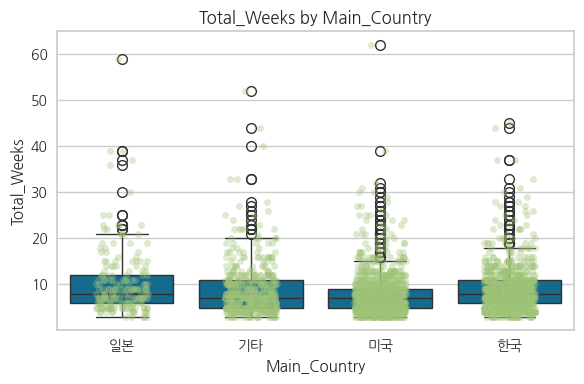


[hit_category] Total_Weeks 요약
               count  median    mean    std  min  max   p25   p75
hit_category                                                    
후반 입소문형         179    16.0  17.827  9.931    4   62  11.0  22.0
중반 균형형          694    10.0  11.291  4.539    4   39   8.0  13.0
초반 폭발형         1695     6.0   6.697  2.791    3   30   5.0   8.0
Median test p=1.73e-156, 전체 중앙값=7.0

쌍별 Cliff’s δ (앞집단>뒷집단 이면 +):
  중반 균형형 vs 초반 폭발형 : δ=0.684
  중반 균형형 vs 후반 입소문형 : δ=-0.468
  초반 폭발형 vs 후반 입소문형 : δ=-0.842


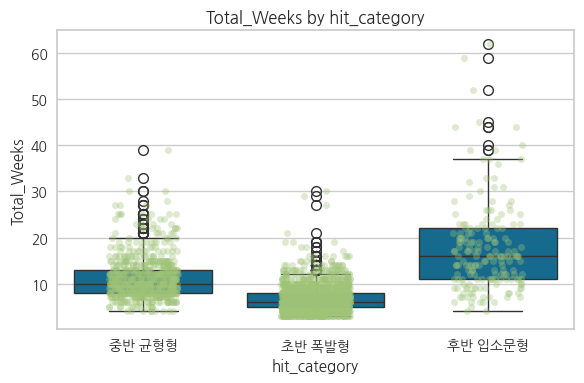

In [357]:
def cliffs_delta(a, b):
    a = np.asarray(a); b = np.asarray(b)
    diff = np.subtract.outer(a, b)
    n = a.size * b.size
    return (np.sum(diff > 0) - np.sum(diff < 0)) / n  # >0이면 앞집단↑

def summarize_direction(df, cat_col, y='Total_Weeks'):
    # 1) 요약통계
    summ = (df.groupby(cat_col)[y]
              .agg(['count','median','mean','std','min','max',
                    lambda s: np.percentile(s,25),
                    lambda s: np.percentile(s,75)])
              .rename(columns={'<lambda_0>':'p25','<lambda_1>':'p75'})
              .sort_values('median', ascending=False))
    print(f"\n[{cat_col}] Total_Weeks 요약\n", summ.round(3))

    # 2) 전체 중앙값 차이
    groups = [g[y].values for _, g in df.groupby(cat_col)]
    stat, p, med, tbl = median_test(*groups)
    print(f"Median test p={p:.4g}, 전체 중앙값={med}")

    # 3) 쌍별 효과크기(Cliff’s δ)
    levels = list(df[cat_col].dropna().unique())
    print("\n쌍별 Cliff’s δ (앞집단>뒷집단 이면 +):")
    for i in range(len(levels)):
        for j in range(i+1, len(levels)):
            a = df.loc[df[cat_col]==levels[i], y]
            b = df.loc[df[cat_col]==levels[j], y]
            d = cliffs_delta(a, b)
            print(f"  {levels[i]} vs {levels[j]} : δ={d:.3f}")

    # 4) 시각화
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x=cat_col, y=y)
    sns.stripplot(data=df, x=cat_col, y=y, alpha=0.35, jitter=0.2)
    plt.title(f'{y} by {cat_col}')
    plt.tight_layout()
    plt.show()

# 실행 예시
for c in ['Pandemic','Grade','Main_Country','hit_category']:
    summarize_direction(data_week_diff, c, y='Total_Weeks')


# 분석용 데이터 추출

## 영화 흥행 유형 패턴

In [358]:
hit_category_csv = pd.concat([movie_title, hit_category], axis=1)

In [359]:
hit_category_csv.to_csv("movie_hit_category.csv", index=False, encoding="utf-8-sig")

## FA

1. 나는 Month 변수에 계절성 변환을 사용하였다. 아래의 코드를 기반으로 변수 생성 필수  
```python
fa_data['Month_sin'] = np.sin(2 * np.pi * fa_data['Month'] / 12)
fa_data['Month_cos'] = np.cos(2 * np.pi * fa_data['Month'] / 12)
```

2. 사용한 표준화 모델 파일 생성

아래의 라이브러리를 사용하였고, fit한 결과를 파일로 저장
```python
from sklearn.preprocessing import StandardScaler
```

In [360]:
import joblib
scaler_bundle={'scaler_model': scaler,
               'feature_list' : num_cols}
joblib.dump(scaler_bundle, 'standard_scaler_FA.pkl')

['standard_scaler_FA.pkl']

joblib.load 함수를 사용하여 불러올 것

3. 사용한 요인분석 모델 파일 생성

In [361]:
fa_bundle={'fa_model': fa,
           'feature_list' : num_cols}
joblib.dump(fa_bundle, 'FA_model.pkl')

['FA_model.pkl']

4. 요인 점수 파일 추출

In [362]:
fa_data_csv = pd.concat([movie_title, factor_scores_df], axis=1)

In [363]:
fa_data_csv.to_csv("fa_data_for_week_predict.csv", index=False, encoding="utf-8-sig")